In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book() # src: https://github.com/fastai/course20/blob/master/fastbook/__init__.py

In [29]:
import fastai.vision.all as fastai
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [6]:
# Prep the images directory
!git clone $HOME/ https://github.com/fastai/fastbook.git
!mv fastbook/images .

fatal: repository '/home/jupyter-master/' does not exist
mv: cannot stat 'fastbook/images': No such file or directory


In [9]:
!rm -fr fastbook

# Under the Hood: Training a Digit Classifier

In [10]:
!pwd

/home/jupyter-master/learning_ML/fast.ai - clean


In [31]:
# Download and untar in the same directory
# This is just a sample of 7's and 3's
path = untar_data(URLs.MNIST_SAMPLE)

In [32]:
Path.BASE_PATH = path

In [33]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [34]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [35]:
# Load file names into variables
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [23]:
im3_path = threes[10]
im3 = Image.open(im3_path)
im3

In [ ]:
# Numpy arrays of the image
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
# Let's print the image with its pixel values
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## First Try: Pixel Similarity


We need to figure out a way to tell if a given image is a 3 or not. How are we going to do that?

One idea is to average all the pixel values of all the training images and create an ideal image of a 3 with those average values.

Then, given a sample image of a number, we can calculate its distance/difference from the ideal 3 (average values) and deduce a result.

The result will be how close to an ideal 3 is the given test image.

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)
type(three_tensors)

list

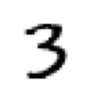

In [ ]:
show_image(three_tensors[1]);

Now we have created a list of tensors.

In order to work on all the tensors at the same time, we need to concatenate them into a rank-3 tensor.

Additionally, we convert the pixel values into floats and normalize them by dividing them by 255 so that their values are in the [0, 1] range.

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.stack.html
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
type(stacked_threes)

torch.Tensor

In [ ]:
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes.shape) # Rank-3 tensor

3

In [ ]:
stacked_threes.ndim

3

**How does an "ideal 3" and "ideal 7" look like?**

Calculate the "ideal 3" by averaging the values of all the pixesl of 3's in the tensors along the dimension 0.

Dimension 0: run through all the images in the tensor and calculate the average values of all the pixels.

We have 6131 of images indicated by dimension 0.

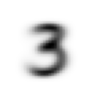

In [ ]:
mean3 = stacked_threes.mean(0) # docs: https://pytorch.org/docs/stable/generated/torch.Tensor.mean.html#torch-tensor-mean
show_image(mean3);

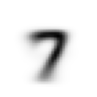

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

We take an arbitrary 3 from our set to compare it against the "ideal 3".

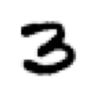

In [ ]:
a_3 = stacked_threes[412] # Random sample of 3
show_image(a_3); # src: https://github.com/fastai/fastai/blob/43dbef38fe52b8b074d91ee1773e702a1401a486/fastai/torch_core.py#L65

We need to calculate the difference between the "ideal 3" and a random 3.

If we just subtract the values of the pixels, we might end up with negative numbers. Pixels cannot have negative numbers.

Instead, we use `L1` and `L2` norms to calculate the difference between the numbers.

Explanation of `L1` and `L2` norms: https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean() # This is identical to dist_3_abs = (a_3 - mean3).abs().sum()/(28*28)
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1638), tensor(0.2961))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.2363), tensor(0.4050))

PyTorch already provides both of these as loss functions. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [ ]:
F.l1_loss(a_3.float(), mean3), F.mse_loss(a_3, mean3).sqrt()

(tensor(0.1638), tensor(0.2961))

In [ ]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.2363), tensor(0.4050))

## Computing Metrics Using Broadcasting

Normally, we use accuracy as the metric for classification models.

Lets create the validation **tensor** sets for the 3's and 7's

In [ ]:
valid_3_tensors = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tensors = valid_3_tensors.float()/255
valid_7_tensors = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tensors = valid_7_tensors.float()/255
valid_3_tensors.shape,valid_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

We write a function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section.

In [ ]:
def mnist_distance(a, b):
  """ Function to calculate the L1 norm between 2 tensors. """
  return (a - b).abs().mean((-1, -2))
mnist_distance(a_3, mean3) # Calculate distance between 2 image tensors.

tensor(0.1638)

We take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tensors`, the tensor that represents the 3s validation set:

In [ ]:
valid_3_dist = mnist_distance(valid_3_tensors, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1580, 0.1157, 0.1638,  ..., 0.1383, 0.1445, 0.1493]),
 torch.Size([1010]))

The function returned the distance for every single image as a vector.

When PyTorch tries to perform a simple subtraction operation between two tensors of different ranks, will use **broadcasting**. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank.

In other words, it applied the subtraction to all the tensors in the `valid_3_tensors`.

`mean((-1,-2))`: The tupple `(-1, -2)` refers to the axes over which we want to have the average values calculated. In this case, these values refer to the last 2 axes which represent the pixels `(28x28)` - the horizontal and vertical dimensions of an image.

After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (`1010`).

So, how do we tell if an image is a `3` or not. We use the following (`is_3`) function which will return a `True` or `False` by comparing the distance (from above) between a given image from the "ideal 3" and the "ideal 7".

It's quite elementary, but should work.

In [ ]:
def is_3(x):
  """ Return True if distance from Ideal 3 is > than distance from Ideal 7 """
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [ ]:
a_3 = stacked_threes[12] # Select a random image
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
# We use broadcasting on the whole validation set
is_3(valid_3_tensors), is_3(valid_7_tensors)

(tensor([False,  True,  True,  ..., False,  True, False]),
 tensor([False, False, False,  ..., False, False, False]))

In [ ]:
is_3(valid_3_tensors).float(), is_3(valid_7_tensors).float() # 1.0 == True and 0.0 == False

(tensor([0., 1., 1.,  ..., 0., 1., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [ ]:
accuracy_3s =      is_3(valid_3_tensors).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tensors).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

We see that the `accuracy` of predicting whether a number is a 7 or not is not 1.0 That is because there are cases in which the distance `mnist_distance(x,mean3) < mnist_distance(x,mean7)` will result into `False`. That means that the distance between the "Ideal 3" and the (validation) image is greater than the distance distance from the "Ideal 7".

So the function will make mistakes in cases in which the distance of a 3 is greater than the distance from a 7.


It's important to note that until this point, the system is not learning, we're just using functions.

## Stochastic Gradient Descent (SGD)

**This section is an illustration in which assuming that `f(x)=x^2` is a loss function, how adjusting the parameter `x` increases - or decreases - the loss.**

We need to set some kind of mechanism which will automatically adjust a set of weights/variables so as to maximize the performance of our predictions.

This is the key to allowing us to have a model that can get better and better—that can learn.

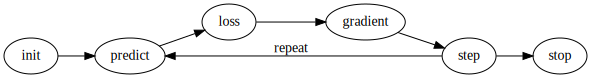

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. Initialize:: the weights - random values
2. Predict:: For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Loss:: Based on these predictions, calculate how good the model is (its loss).
4. Gradient:: Calculate the gradient, which measures for each weight, how changing that weight would change the loss.
5. Step:: Step (that is, change) all the weights based on that calculation.
6. Predict:: Go back to the step 2, and repeat the process.

Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

Let's define a simple quadratic function and pretend that this is our loss function and `x` is the weight parameter.

In [ ]:
def f(x):
  return x**2

We pick some random value for the parameter `x`.
Let's say it's `1.5` and calculating the value of the loss.

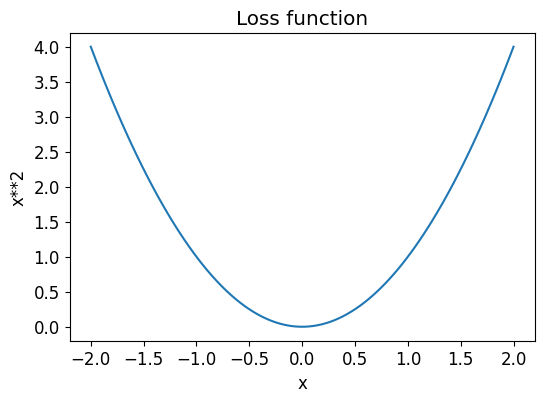

In [ ]:
plot_function(f, 'x', 'x**2', title="Loss function")

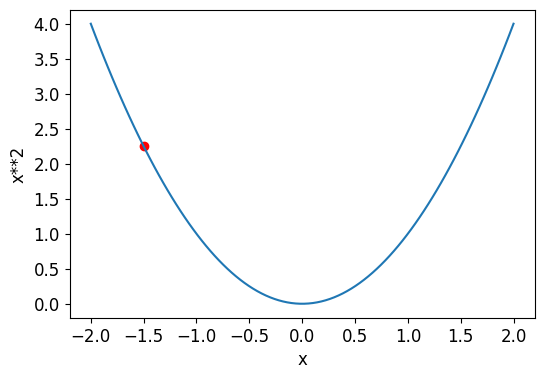

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

In [ ]:
# Value of loss at 1.5
f(1.5)

2.25

If we increase or decrease the parameter by a little bit - the adjustment - we see how the value of the loss changes.

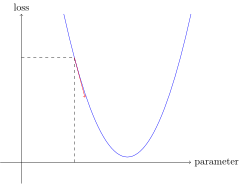

In [ ]:
from IPython.display import SVG, display
display(SVG(filename="./images/grad_illustration.svg"))

We can change our weight by a little **in the direction of the slope**, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

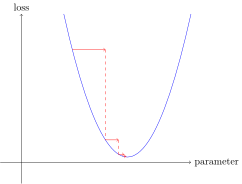

In [ ]:
display(SVG(filename="images/chapter2_perfect.svg"))

This basic idea of decreasing the loss is the way we optimize functions.

### Calculating Gradients

The calculation of `gradients` is based on the calculation of the values of the `derivative` of a function.

The gradients will tell us how much we have to change each weight to make our model better. Because, the derivative of a function tells you how much a change in its parameters will change its result.

So, from the function above:

```
the derivative of f(x) is f'(x)=2*x
the values of f(1.5)=2.25
if we change x by 0.5 then f(-1)=1
```

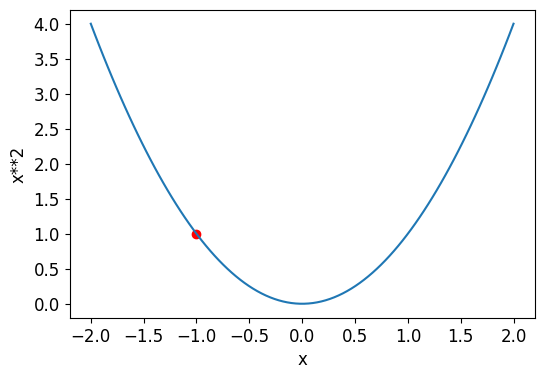

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1., f(-1.), color='red');

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

PyTorch is able to automatically compute the derivative of nearly any function.

Here's an example

In [ ]:
xt = tensor(3.).requires_grad_() # This is just a random value
xt.size(), xt

(torch.Size([]), tensor(3., requires_grad=True))

THe method `requires_grad_` tells PyTorch that we want to calculate gradients with respect to that variable at that value.

In [ ]:
# We calculate the value of our function with the above weight.
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
# Calculate the gradients for us
yt.backward()

The "backward" here refers to `backpropagation`, which is the name given to the process of calculating the derivative of each layer.

In [ ]:
# View the gradients by checking teh grad attribute
xt.grad

tensor(6.)

We do the same steps but, now using a vector.

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [ ]:
def f(x):
  return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

**The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters.** But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate

### An End-to-End SGD Example

**Deciding how to change the parameters based on the values of the gradients is an important part of the deep learning process.**

**Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the `learning rate (LR)`.**

The `LR` is a number between 0.001 and 0.1.

Often, people select a learning rate just by trying a few, and finding which results in the best model after training.

We adjust the weights using the `LR` like `w -= gradient(w) * lr`

This is known as stepping your parameters, using an optimizer step.

The sign in `w -= gradient(w) * lr` shows wether we're increasing or decreasing the parameter. We adjust the parameter towards the direction of the slope.

- If the slope is negative = we increase the parameter.
- If the slope is positive = we decrease the parameter.

**We want to adjust our parameters in the direction of the slope because our goal in deep learning is to minimize the loss.**

Illustration of small `LR`

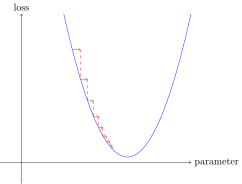

In [ ]:
display(SVG(filename="images/chapter2_small.svg"))

Illustration of a too large `LR`

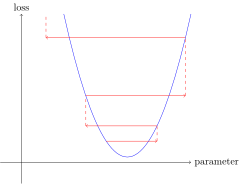

In [ ]:
display(SVG(filename="images/chapter2_div.svg"))

If the learning rate is too high, it may also "bounce" around

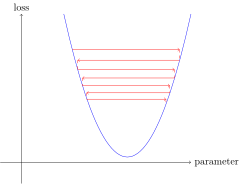

In [ ]:
display(SVG("images/chapter2_bouncy.svg"))

Lets build a model of how the speed changes over time.

In [ ]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

Random speed numbers over time.

We randomly guess that the speed function is a quadratic one of the form `a*(time**2)+(b*time)+c`.

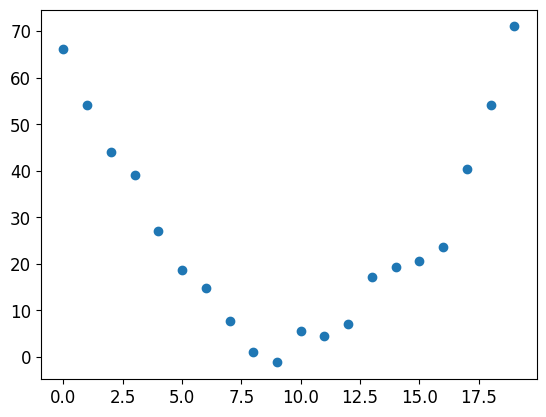

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1 # f(x)=ax^2+by+c
plt.scatter(time,speed);

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define which quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, t, and the parameters, params, in the function's signature:

In [ ]:
# Define the speed function in python.
def speed_function(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

By picking the quadratic function above, we simplified our problem of finding the speed (of the rollercoaster) by finding the "best" values for `a`, `b` and `c` (which predict the speed).

But, what do we mean by "best"? We define this by choosing a loss function which will return a value based on a prediction and a target.

In [ ]:
def mse(preds, targets):
  return ((preds-targets)**2).mean()

Let's work throught the 7 steps.

#### Step 1: Initialize the parameters

In [ ]:
params = torch.randn(3).requires_grad_()
params

tensor([0.6930, 0.8300, 0.8325], requires_grad=True)

In [ ]:
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [ ]:
# Let's create a function which illustrates our prediction compared to the targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

In [ ]:
preds = speed_function(time, params)

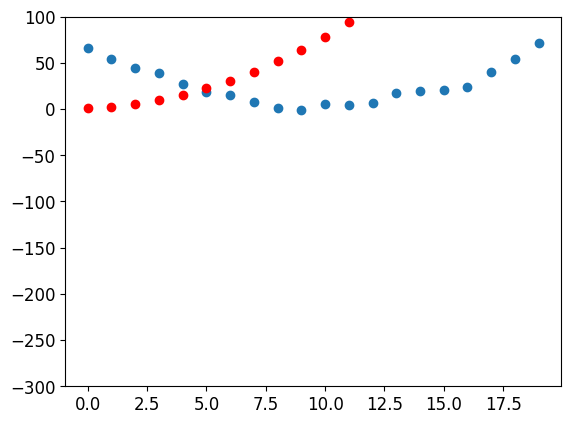

In [ ]:
show_preds(preds)

We can see here, that our `predictions`(red) are not anywhere close to the real values of the speed (blue).

#### Step 3: Calculate the loss

In [ ]:
loss = mse(preds, speed)
loss

tensor(11231.5703, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

We calculate the derivative of the function we are trying to optimize. In this case, this is the `loss` function.

We calculate the gradients of the `loss` function on the `parameter` values.

In [ ]:
loss.backward()
params.grad # This shows how much loss will change if we adjust the a, b and c parameters respectively

tensor([34525.8047,  2224.3140,   135.0935])

In [ ]:
params.grad * 1e-5 # We don't want to make big adjustments, as noted above, so we scale the gradients to smaller values.

tensor([0.3453, 0.0222, 0.0014])

In [ ]:
params

tensor([0.6930, 0.8300, 0.8325], requires_grad=True)

In [ ]:
params.grad.data

tensor([34525.8047,  2224.3140,   135.0935])

#### Step 5: Step the weights.

We updated the parameters based on the gradients we just calculated.

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None # This is the important bit, we need to reset the gradients on the parameters

In [ ]:
preds = speed_function(time,params)
mse(preds, speed)

tensor(2643.0776, grad_fn=<MeanBackward0>)

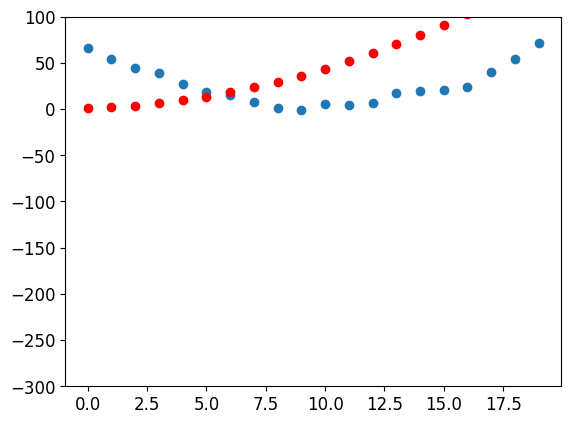

In [ ]:
show_preds(preds)

We can see that the origina `loss` has decreased.

We are going to create a function to apply a single step.

In [ ]:
def apply_step(params, prn=True):
    preds = speed_function(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process

In [ ]:
for i in range(20):
  apply_step(params)

2643.07763671875
1017.8688354492188
710.3269653320312
652.127685546875
641.1117553710938
639.0242919921875
638.6265869140625
638.5484619140625
638.5308837890625
638.524658203125
638.5206909179688
638.5171508789062
638.513671875
638.5101928710938
638.5067138671875
638.5032348632812
638.4996337890625
638.4962158203125
638.49267578125
638.4892578125


In [ ]:
params = orig_params.detach().requires_grad_() # IDK

We plot to show how the `predictions` approach the actual values.

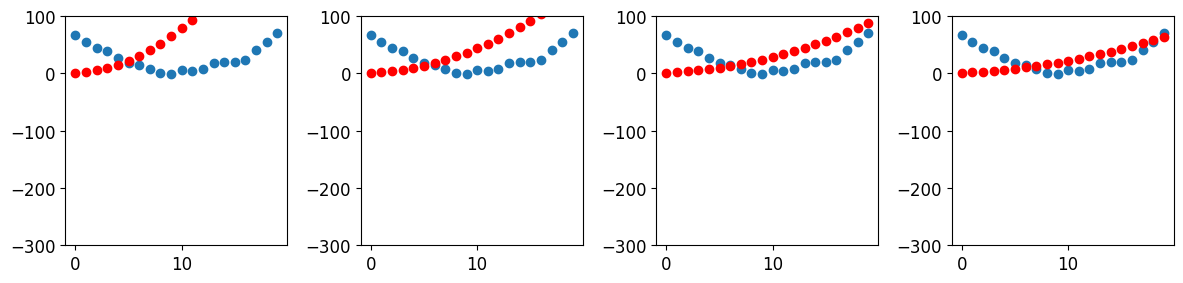

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

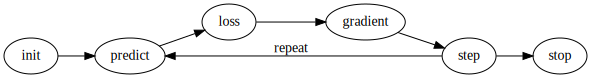

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

The same process, as above, can also be applied to transfer learning. In this case, the parameters come from a pretrained model.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective.

## The MNIST Loss Function

We already have our independent variables `x` —these are the images themselves.

We concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor).

We can do this using view, which is a PyTorch method that changes the shape of a tensor without changing its contents.

`-1` is a special parameter to view that means "make this axis as big as necessary to fit all the data":

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) # docs: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # docs: https://pytorch.org/docs/stable/generated/torch.unsqueeze.html#torch-unsqueeze
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
# valid_3_tensors are the validation images, we could also stack them and do the same as with stacked_threes
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
# Initialize random parameters
def init_params(size, std=1.0):
  """ Return a set of random parameter """
  return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

The function `weights*pixels` won't be flexible enough—it is always equal to `0` when the pixels are equal to `0`. So, we add a random `bias` to compensate for that.

In neural networks, the `w` in the equation `y=w*x+b` is called the `weights`, and the `b` is called the `bias`. **Together, the weights and bias make up the parameters.**

In [ ]:
weights[0:10], bias

(tensor([[-0.0744],
         [ 1.6374],
         [ 0.4509],
         [ 0.1214],
         [-0.8981],
         [-1.9608],
         [-0.7001],
         [ 0.9125],
         [ 2.9114],
         [-1.5774]], grad_fn=<SliceBackward0>),
 tensor([-1.7600], requires_grad=True))

In [ ]:
# Calculate the prediction for an image
(train_x[10]*weights.T).sum() + bias # y=w*x+b

tensor([4.6791], grad_fn=<AddBackward0>)

We could use a `for` loop to calculate the predictions for each image. However, that would've been slow because **python's `for loop` are slow. Thus we use the matrix multiplication operator -`@`.**

In [ ]:
# What matrix multiplication looks like
display(SVG("images/matmul2.svg"))

In [ ]:
# Create the matrix multiplication function
def linear1(xb):
  """ Runs the matrix multiplication of xb@weights+bias """
  return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[13.7334],
        [-0.3154],
        [ 4.8783],
        ...,
        [-5.1974],
        [-0.7339],
        [ 6.7047]], grad_fn=<AddBackward0>)

In [ ]:
# We check the accuracy
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [ True],
        [ True],
        [False]])

In [ ]:
# Overall accuracy
corrects.float().mean().item()

0.6502904295921326

Let's see what the change in accuracy is for a small change in one of the weights.

In [ ]:
with torch.no_grad():
  weights[0] *= 1.0001

In [ ]:
# Re calculate the predictions
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6502904295921326

Here we see no change in the the `accuracy`! Why?

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients** we need some loss function that represents how good our model is**. That is because **the gradients are a measure of how that loss function changes with small tweaks to the weights**.

Why can we not use `accuracy` for improving our model?

The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, **meaning that their difference is very small**. But `accuracy` only changes at all when a prediction changes from a 3 to a 7, or vice versa.

So, the problem is that **a small change in `weights` from `x_old to x_new` isn't likely to cause any prediction to change**, so `(y_new - y_old)` will almost always be `0`. **In other words, the gradient is 0 almost everywhere.**

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. In this case it means if the correct answer is a `3` the score is a little higher, or if the correct answer is `7`, the score is a little lower.

Let's construct such a loss function.

The `loss` function will take 2 inputs, just like before. The inputs are the `predictions` and the `targets` values.

It will calculate the distance between them return it as an average number.

Assume we have 2 tensors.
`targets`: shows the actual labels
`predictions`: shows the predicted label/values from the model

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a `loss` function that `measures the distance between predictions and targets`.

this function will measure how distant each prediction is from `1` if it should be `1`, and how distant it is from `0` if it should be `0`, and then it will take the mean of all those distances. **So, it actually measures the loss.**

Since we need a scalar for the final loss, mnist_loss takes the mean of the previous tensor

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [ ]:
# So, average loss is
mnist_loss(prds,trgts)

tensor(0.4333)

In [ ]:
# If we modify our predictions a little closer to the targets, we get a smaller loss
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

There's a problem with `mnist_loss()`. As it's currently defined **it assumes that the predictions are always between 0 and 1**. However, as we can see bellow, they are not. We need to ensure that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

In [ ]:
preds

tensor([[13.7334],
        [-0.3154],
        [ 4.8783],
        ...,
        [-5.1974],
        [-0.7339],
        [ 6.7047]], grad_fn=<AddBackward0>)

In [ ]:
# The following will not generate a useful number
mnist_loss(train_x, train_y)

tensor(0.4825)

### Sigmoid

The sigmoid function always outputs a number between 0 and 1. It's defined as follows:

In [ ]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

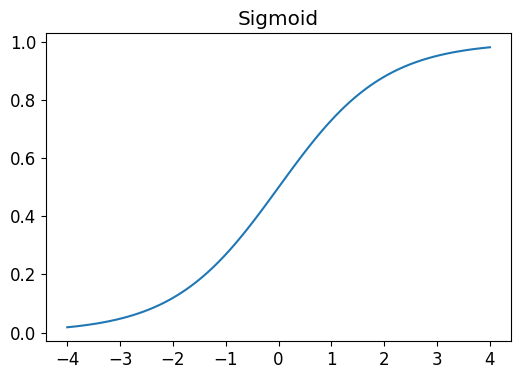

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

This function takes any values (positive or negative) and produces a values between 0 and 1.

It's also a smooth curve which only goes up which makes it easier for SGD to find meaningful gradients.

Let's update `mnist_loss()` to apply the `sigmoid` function on the `predictions` first.

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

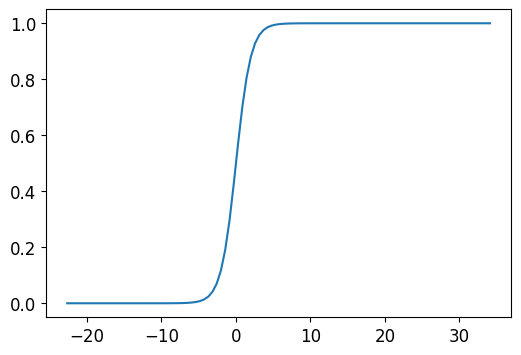

In [ ]:
plot_function(torch.sigmoid, min=float(preds.min()), max=float(preds.max()))

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence-an image is a 3.

So why did we define a `loss` function even though we had the `accuracy`?

The key difference is that **the metric is to drive human understanding** and **the loss is to drive automated learning**. To drive automated learning, **the loss must be a function that has a meaningful derivative**. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. **It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.**

### SGD and Mini-Batches

We calculate the average loss for a few data items at a time. This is called a mini-batch.

The number of items in the `mini-batch` is called the `batch size`.

The `batch size` will define the trainin speed and accuracy of the model.

To train the model more effectively, we want to randomly shuffle our dataset on every epoch, before we creating `mini-batches`.

The `DataLoader` does this for us.

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([13,  0, 11,  4, 12]),
 tensor([10,  1,  7, 14,  3]),
 tensor([9, 2, 8, 5, 6])]

To train our model we need a collection of independent and dependent variables, which represent our inputs and targets.

`x` is independent = inputs (predictions)
`y` is dependent = targets (label)

The collection of tupples of independent and dependent variables is known as `Dataset`. For example:

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we get `mini-batches`.

These `mini-batches` are `tupples` or `tensors`.

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([14,  8,  5, 11, 25, 16]), ('o', 'i', 'f', 'l', 'z', 'q')),
 (tensor([18,  6, 13, 20,  7,  1]), ('s', 'g', 'n', 'u', 'h', 'b')),
 (tensor([ 2,  4, 22, 12,  0, 10]), ('c', 'e', 'w', 'm', 'a', 'k')),
 (tensor([17, 15, 21,  9, 24,  3]), ('r', 'p', 'v', 'j', 'y', 'd')),
 (tensor([19, 23]), ('t', 'x'))]

## Putting It All Together

We are going to put our `loss` and `SGD` functions together in our 7 step approach.

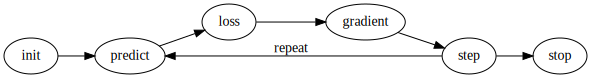

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

### Prepare datasets

Before doing anyting, we need to prepare out datasets

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A Dataset in PyTorch is required to return a tuple of `(x,y)` when indexed.

In [ ]:
# Demonstration of how creating a Dataset works using only built-in Python
train_dataset = list(zip(train_x, train_y)) # Collection of independent and dependent variables
x,y = train_dataset[0]
x.shape, y, type(x), type(y)

(torch.Size([784]), tensor([1]), torch.Tensor, torch.Tensor)

In [ ]:
# Create the DataLoader for the training dataset
train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True) # Why the images have not been randomized ? ? ? ?
xb,yb = first(train_dl)
xb.shape,yb.shape # Just a single tensor pair in the dataset

(torch.Size([256, 784]), torch.Size([256, 1]))

In [ ]:
#valid_3_tensors = torch.stack([tensor(Image.open(o))
#                            for o in (path/'valid'/'3').ls()])
#valid_3_tensors = valid_3_tensors.float()/255
#-------------------------------------------------------------------

# valid_3_tensors are the validation images, we could also stack them and do the same as with stacked_threes
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

In [ ]:
# Create the DataLoader for the validation dataset; the values are not randomized
valid_dl = DataLoader(valid_dataset, batch_size=256, shuffle=True)

### Let's test our approach with a small mini-batch first

That's to test our understanding and validate the approach.

In [ ]:
# 1. Initialize params
weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias

# Create a mini-batch of 10 items
train_batch = train_x[:10]
valid_batch = valid_y[:10]

# 2. Calculate the predictions
preds = linear1(train_batch)

# 3. Calculate the loss
loss = mnist_loss(preds, valid_batch)

# 4. Calculate the gradient
loss.backward()

# 5. Update parameters (step)
for p in params:
  p.data -= p.grad * lr
  p.grad.zero_() # Note this is an inline replacement

Let's see the accuracy of the model.

In [ ]:
valid_batch

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [ ]:
preds, (preds>0.0).float() == valid_batch

(tensor([[ 2.3889],
         [ 9.1074],
         [10.5157],
         [-2.9623],
         [ 4.1610],
         [11.6520],
         [ 2.6821],
         [ 7.2328],
         [ 0.8178],
         [ 2.5266]], grad_fn=<AddBackward0>),
 tensor([[ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True]]))

In [ ]:
# Calculate the average accuracy
preds = preds.sigmoid()
correct = (preds>0.5) == valid_batch
correct.float().mean() # This should correspond to the result from the accuracy calculation

tensor(0.9000)

In [ ]:
loss

tensor(0.1495, grad_fn=<MeanBackward0>)

### Put everything together for a larger dataset

`train_dl` and `valid_dl`



In [ ]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
# 1. Init the params
def set_params():
  weights = init_params((28*28,1))
  bias = init_params(1)
  return weights, bias


In [ ]:
# 2. Calculate the predictions, loss
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [ ]:
# 3. Calculate gradient and Update parameters (step)
def train_epoch(model, lr, params):
  """ Trains the model for one epoch. Training for one epoch is equal to the training on the size of the mini-batch-256 images """
  for xb, yb, in train_dl: # Extracts each mini-batch from the DataLoader
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

In [ ]:
# Print the average accuracy of the model
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
def validate_epoch(model):
  """ Returns mean accuracy from the validation dataloader """
  total_accuracy = []
  for xb, yb in valid_dl:
    total_accuracy.append(batch_accuracy(model(xb), yb))
  return round(torch.stack(total_accuracy).mean().item(), 4)

In [ ]:
params = set_params()
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9765

Let's train the model for a few epochs.

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)
parameters = weights, bias
lr = 1

for e in range(20):
  train_epoch(linear1, lr, parameters)
  print(validate_epoch(linear1), end=" ") # Outputs the accuracy for each epoch;Should be going UP

0.8474 0.926 0.9459 0.9574 0.9623 0.9641 0.9657 0.9666 0.9676 0.9685 0.969 0.9705 0.9716 0.972 0.9721 0.9726 0.9735 0.9735 0.974 0.9755 

### Creating an Optimizer

An `optimizer` is an object that performs the `SGD` In PyTorch.

`PyTorch` provides the bundle of a `model` and `parameters` (`weights` and `bias`) in a single module. That module is called `nn.Linear`.

It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [ ]:
linear_model = nn.Linear(28*28,1) # Applies a linear transformation to the incoming data :math:`y = xA^T + b`

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [ ]:
class BasicOptimizer:
    """ Our handwriten basic optimizer """

    def __init__(self, params, lr):
      self.params = list(params)
      self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
          p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
          p.grad = None

In [ ]:
# Create our optimizer
opt = BasicOptimizer(linear_model.parameters(), lr)

Since our model handles the creation of weghts and bias, we simplify our training loop.

In [ ]:
def train_epoch(model):
    """ New function which trains the model without handling parameter update """
    for xb, yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step() # The optimizer handler parameter update
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model) # if you re-run this after the model has been trained, it should be higher than before.

0.4695

In [ ]:
def train_model(model, epochs):
    """ Trains the model for a number of epochs """
    for _ in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

0.9721 0.975 0.977 0.9784 0.977 0.978 0.9784 0.9794 0.9789 0.9804 0.9794 0.9794 0.9794 0.9808 0.9814 0.9808 0.9824 0.9829 0.9829 0.9823 

`fastai` provides `SGD` class which does the same thing as our hand-writen `BasicOptimizer()`.

In [ ]:
linear_model = nn.Linear(28*28,1) # Re-define the model
opt = SGD(linear_model.parameters(), lr) # Initialize optimizer, docs: https://docs.fast.ai/optimizer.html#sgd
train_model(linear_model, 20) # Train the model

0.9695 0.9754 0.9759 0.977 0.9794 0.9784 0.9794 0.9789 0.9803 0.9794 0.9799 0.9804 0.9814 0.9814 0.9813 0.9819 0.9819 0.9818 0.9814 0.9819 

We are gradually substibutin the hand-writen function with functions provided by `fastai`.

`fastai` also provides `Learner.fit`, which substitutes `train_model()`.

To create a `Learner` we first need to create a `DataLoaders`, by passing in our **training and validation DataLoaders**:

In [ ]:
dls = DataLoaders(train_dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr) # train the model for 10 epochs

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.057947,0.040850,0.971541,00:00
1,0.039965,0.034251,0.974975,00:00
2,0.032434,0.031637,0.976448,00:00
3,0.028085,0.029360,0.977920,00:00
4,0.025726,0.027982,0.978410,00:00
5,0.023891,0.026874,0.979392,00:00
6,0.022417,0.026797,0.978901,00:00
7,0.021609,0.025318,0.979392,00:00
8,0.021054,0.025304,0.979882,00:00
9,0.020276,0.024675,0.979882,00:00


We have gradually substibuted out hand-writen functions with ones provides by `fastai` and `pytorch`.

The point here is that these are just libraries which implement our basic-handwriten functionality.

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [ ]:
def simple_net(xb):
    """ Returns a non-linear neural network """
    res = xb@w1 + b1 # Layer 1
    res = res.max(tensor(0.0)) #Layer 2 # Takes either the number of res, or 0.0 == ReLU
    res = res@w2 + b2 # Layer 3
    return res

`simple_net()` consists is two linear classifiers with a max function between them.

Next we initialize the parameters.

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

`w1` has 30 output activations. Which means that `w2` must have 30 input activations, so they match.

That **means that the first layer can construct 30 different features**, each representing some **different mix of pixels**. You **can change that 30 to anything you like**, to make the model more or less complex.

`res.max(tensor(0.0))` is called a rectified linear unit, also known as ReLU. In `pytcorch` it's defined as `F.relu`. It replaces every negative number into 0.

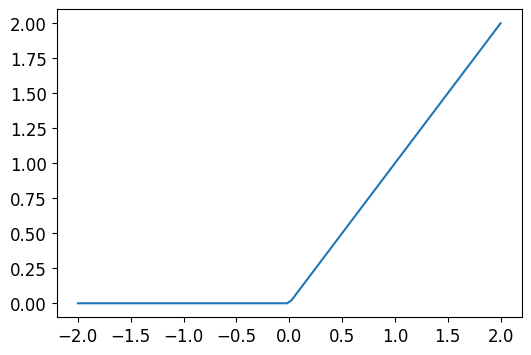

In [ ]:
plot_function(F.relu)

Mathematically, we say the **composition of two linear functions is another linear function**.

This means that if we just add 2 linear function, without a non-linear one in between, why not just replace the 2 linear functions with one?

So, if we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

It's proven in the `universa approximation theorem` that the `simple_net()` function can solve and computable problem to an arbitrary high level of accuracy. How? By finding the right paramters for `w1` and `w2` and making the matrices large enough.

For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines.

This is known as the universal approximation theorem.

The 3 lines of code in `simple_net()` are known as layers.
**bold text**

 - the first and thirs layers are linear
 - the second (middle) layer known as variously nonlinear - **activation function**

 Just as before, we can replace this hand-writen code with `pytorch` functions.

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # Layer 1 - linear
    nn.ReLU(), # Layer 2 nonlinear - activation function
    nn.Linear(30,1) # Layer 3 - linear
)



Let's combine the `simple_net` in a `Learner`. Remember `Learner()` replaces the `train_model()`.

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1) # Run training for 40 epochs with lr=0.1

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.241012,0.094161,0.967125,00:00
1,0.112714,0.053751,0.969087,00:00
2,0.068293,0.044084,0.971050,00:00
3,0.048716,0.039193,0.972522,00:00
4,0.039307,0.036248,0.973013,00:00
5,0.033997,0.034171,0.974485,00:00
6,0.030846,0.032576,0.976448,00:00
7,0.028058,0.031129,0.976938,00:00
8,0.026582,0.030268,0.976448,00:00
9,0.025285,0.029341,0.976938,00:00


The numbers generated from the training, such as `accuracy` and `loss`, are recorded in the `learn.recorder.values`.

Let's plot `accuracy` over training.

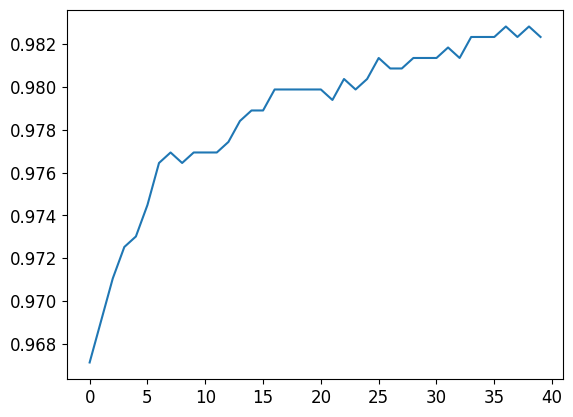

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
# Final accuracy
learn.recorder.values[-1][2]

0.98233562707901

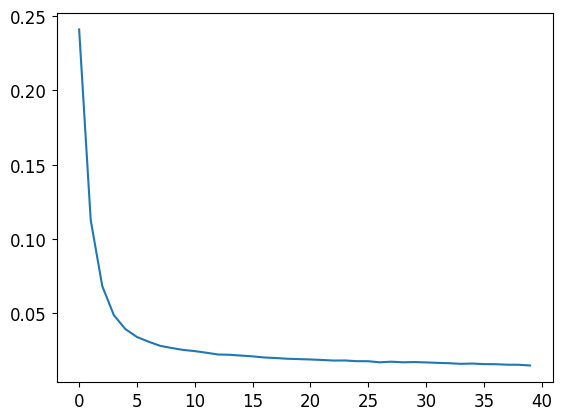

In [ ]:
# Plot training loss over epochs
plt.plot(L(learn.recorder.values).itemgot(0))

At this point we have deciphered the magic:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
2. A way to find the best set of parameters for any function (stochastic gradient descent)

**This combination of simple techniques can really solve any problem.**

### Going Deeper

There is no need to stop at just two linear layers. We can add as many as we want, as long as we **add a nonlinearity between each pair of linear layers**.

However, the deeper the model, the harder it gets to optimize the parameters.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So, why use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

- `more layers` == smaller pamaters matrices == increased performance == increased accuracy
- `less layers` == larger pameter matrices == decreased performance == decreased accuracy

That means that we can train the model more quickly, and it will take up less memory.

Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here's one with 18 layers.

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.090305,0.013248,0.995093,00:24


We can see here that with a training of 1 epoch, the NN returns an accuracy of almost 100%. This is quite the difference compared to our neural network (with 3 layers).

## Jargon Recap

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

Activations:: Numbers that are calculated (both by linear and nonlinear layers)
Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

Activations and parameters are all contained in tensors.

A NN typically alternates between a linear and nonlinear function in each layer.

Sometimes a nonlinearity is referred to as an activation function.

`ReLU`: Function that returns 0 for negative numbers and doesn't change positive numbers.

`Mini-batch`:
A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).

`Forward pass`: Applying the model to some input and computing the predictions.

`Loss`: A value that represents how well (or badly) our model is doing.

`Gradient`: The derivative of the loss with respect to some parameter of the model.B

`Backward pass`: Computing the gradients of the loss with respect to all model parameters.

`Gradient descent`: Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.

`Learning rate`: The size of the step we take when applying `SGD` to update the parameters of the model.

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.